In [77]:
import sys
import os

# Dynamically add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

In [78]:
#import external libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns



from db_config import db
from db_config.db_tables import Matches, Offer



In [79]:
# Initialize empty lists for matchings and matching scores
matchings = []
matchings_entries = []
matching_score = 0

#define matching score function
# Calculate matching score based on euclidean distance
def calculate_matching_score(df, user1, user2):
    user1_preferences = df[df['user_id'] == user1].drop(['user_id'], axis=1).apply(pd.to_numeric, errors='coerce').fillna(0).values.flatten()
    user2_preferences = df[df['user_id'] == user2].drop(['user_id'], axis=1).apply(pd.to_numeric, errors='coerce').fillna(0).values.flatten()
    return euclidean(user1_preferences, user2_preferences)

In [120]:
#this cell compares the matching scores for train and test data to improve performance and avoid overfitting

from app import app

with app.app_context():
    
    df = pd.read_sql('SELECT * FROM preferences', db.engine)
    df_later = df.copy()
    #replace NaNs with True to avoid errors
    df = df.fillna(True)

    #  Define features and hot-encode categorical variables
    X = pd.get_dummies(df[["semester", "attendance"]])

    #make sure true and false are replaced with 0 and 1
    X = np.where(X == True, 1, X)
    X = np.where(X == False, 0, X)

    # Split the data into training and testing sets (5 fold cross validation) to see how to model performs on unseen data
    X_train, X_test, df_train, df_test = train_test_split(X, df, test_size=0.2, random_state=42)

    #Standardize features (preprocessing to improve model performance)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Ensure df_train and X_train have the same length
    # Define our clusters
    # Define cluster list, start from 10 so that silhouette score can be calculated
    cluster_amount = list(range(10, 100))
    best_score = -1
    best_cluster = None
    for i in cluster_amount:
        kmeans = KMeans(n_clusters=i)
        # Fit the model
        df_train['cluster'] = kmeans.fit_predict(X_train)
        
        # Check if any cluster is too small
        cluster_sizes = df_train['cluster'].value_counts()
        min_cluster_size = 3  # we want at least 3 matches in each cluster
        if any(cluster_sizes < min_cluster_size):
            continue  # Skip this iteration and try with a different number of clusters
        # Evaluate performance using the silhouette score and find best performing cluster amount
        silhouette_avg = silhouette_score(X_train, df_train['cluster'])
        if silhouette_avg > best_score:
            best_train_score = silhouette_avg
            best_train_cluster = i
        

        # Evaluate performance on the test set
        for i in cluster_amount:
            kmeans = KMeans(n_clusters=i)
            # Fit the model
            df_test['cluster'] = kmeans.fit_predict(X_test)
            # Check if any cluster is too small
            cluster_sizes = df_test['cluster'].value_counts()
            min_cluster_size = 3  # same as before
            if any(cluster_sizes < min_cluster_size):
                continue  # Skip this iteration and try with a different number of clusters
            # Evaluate performance using the silhouette score and find best performing cluster amount
            silhouette_avg = silhouette_score(X_test, df_test['cluster'])
            if silhouette_avg > best_score:
                best_test_score = silhouette_avg
                best_test_cluster = i

    print(f'Best Train Silhouette Score is: {best_train_score} for {best_train_cluster} clusters')
    print(f'Best Test Silhouette Score is: {best_test_score} for {best_test_cluster} clusters')

#the best amount of clusters is 26 as this results in the highest silhouette score for test data.(Best Train Silhouette Score is: 0.29184346383994514 for 92 clusters
#Best Test Silhouette Score is: 0.2700937411175481 for 26 clusters this is the amount of clusters we use for our application.
#this indicates fairly ok clustering but it should be much higher:
#features could not naturally form spherical clusters, which is the assumption of KMeans.
#the chosen number of cluster is limited by the dataset size (only 100 entries for testing and 400 for training).
#the features might not be independent and identically distributed, which is another assumption of KMeans.
# Best Train Silhouette Score is: 1.0 for 99 clusters for features semester and attendance
# Best Test Silhouette Score is: 0.8368340765134468 for 20 clusters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (31). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (32). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found small

Best Train Silhouette Score is: 1.0 for 99 clusters
Best Test Silhouette Score is: 0.8368340765134468 for 20 clusters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (31). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (32). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found small

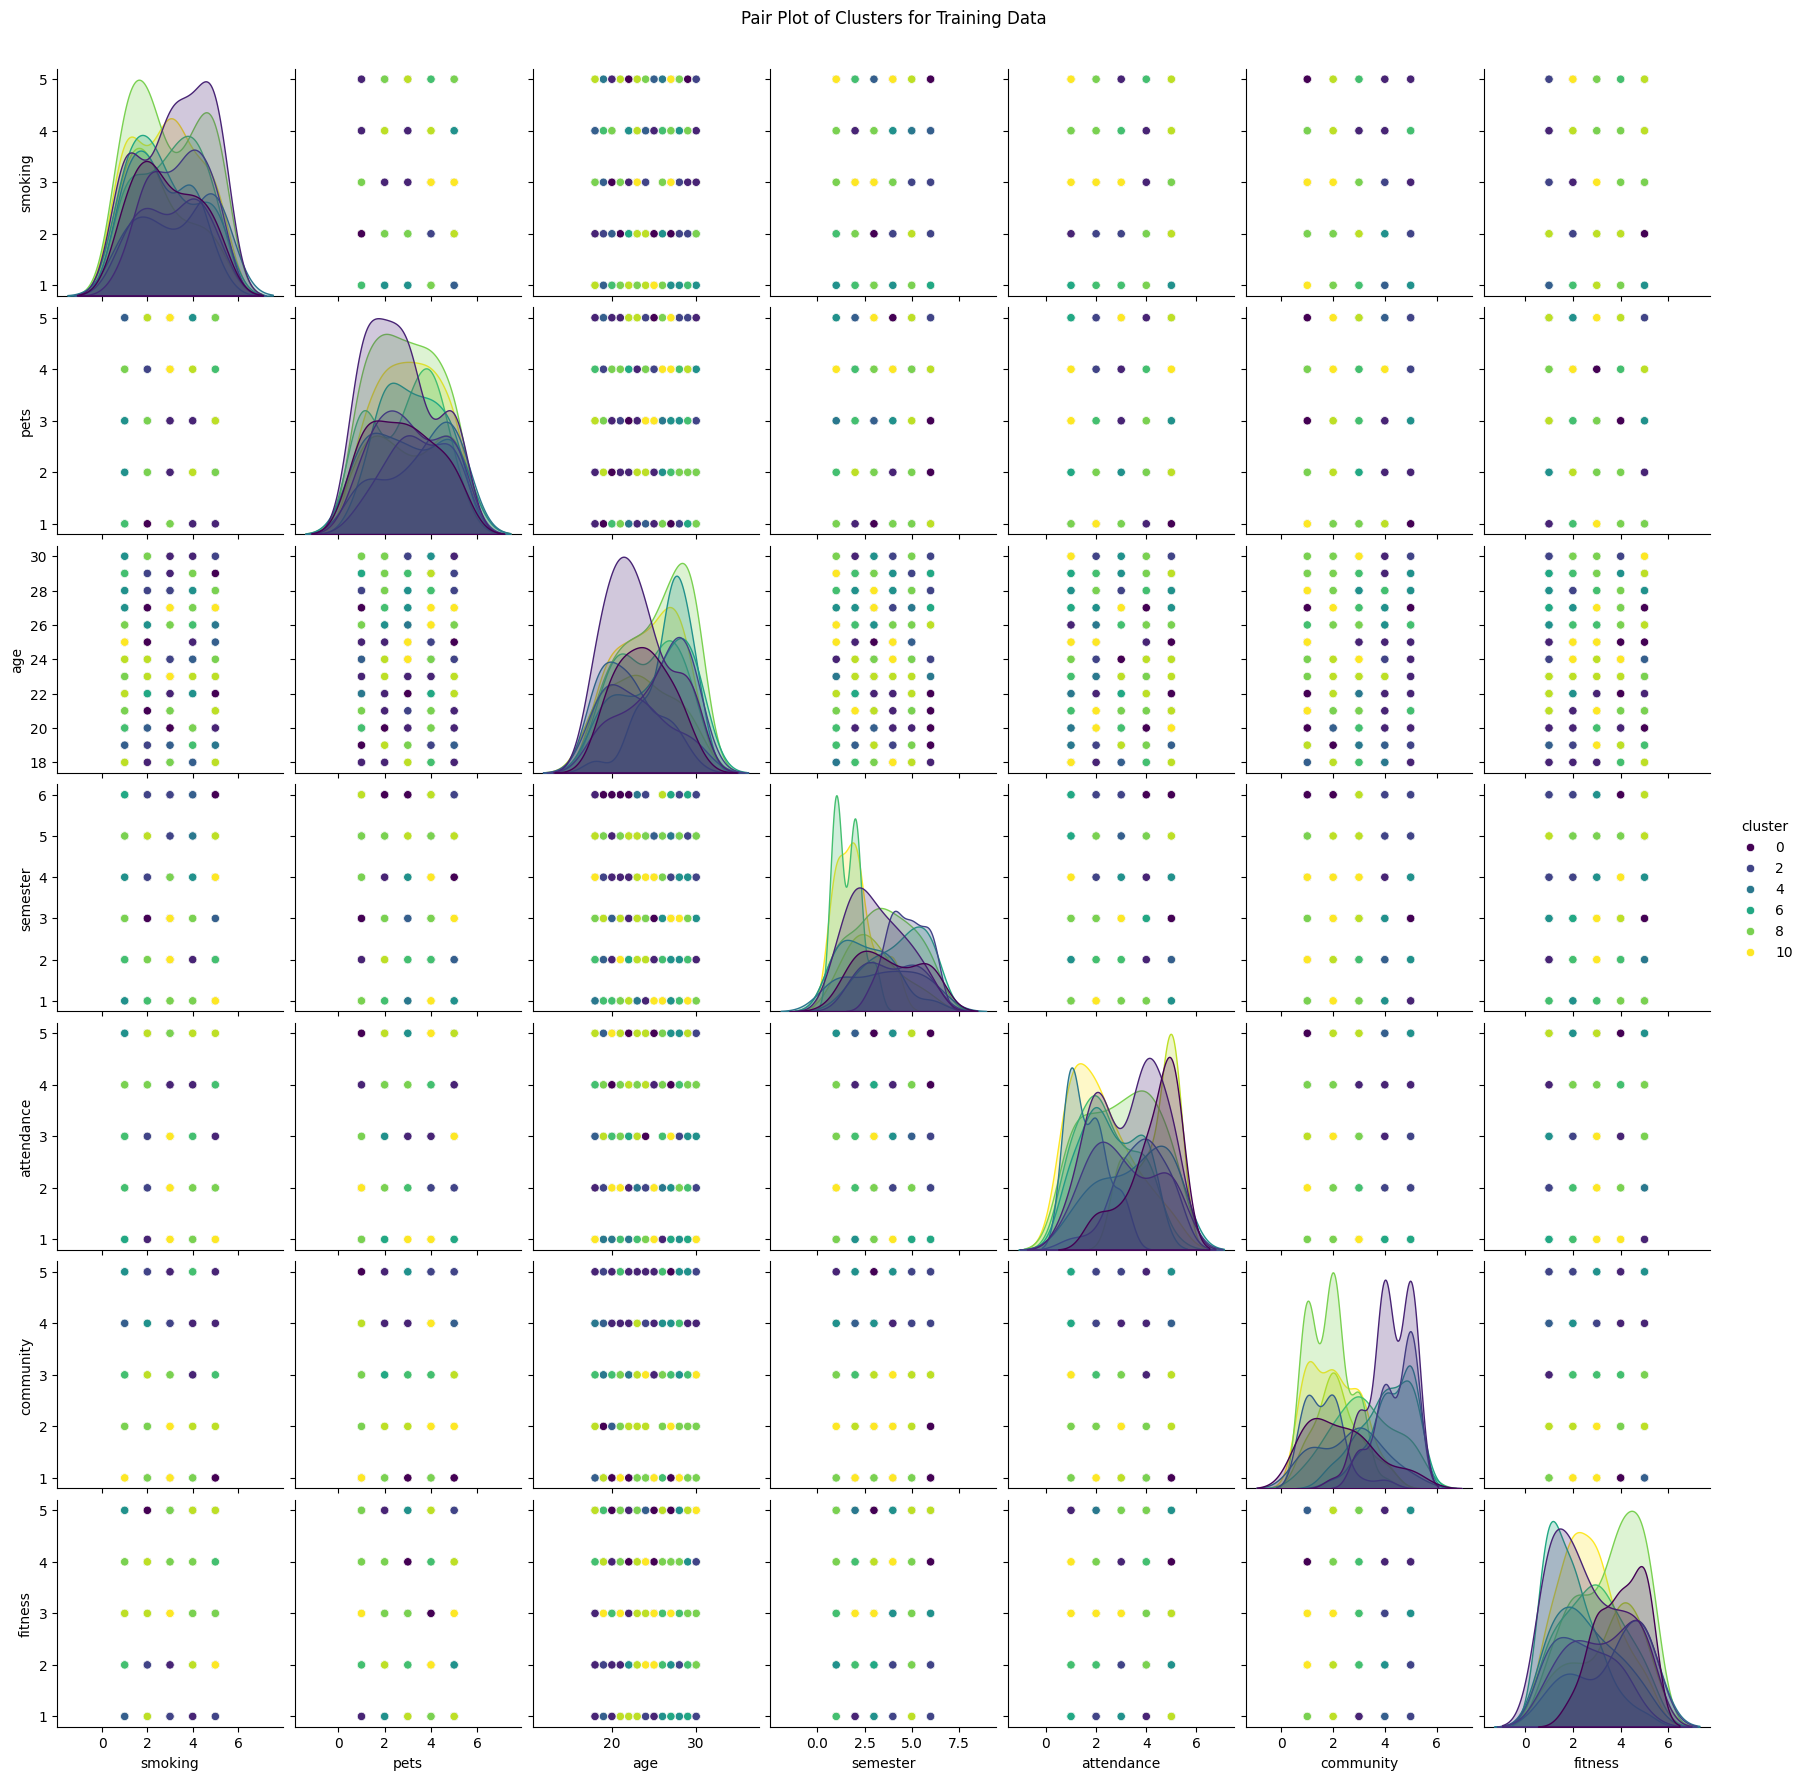

In [68]:
import seaborn as sns

# Create a DataFrame with the training data and cluster labels
df_train_clustered = df_train.copy()
df_train_clustered['cluster'] = df_train['cluster']

# Select a subset of features for visualization
features_to_plot = ["smoking", "pets", "age", "semester", "attendance", "community", "fitness"]

# Create a pair plot with the selected features and color by cluster
sns.pairplot(df_train_clustered, vars=features_to_plot, hue='cluster', palette='viridis')
plt.suptitle('Pair Plot of Clusters for Training Data', y=1.02)
plt.show()

#Interpretation of the pair plot:
# semester: Strong separation in both diagonal and scatter plots, particularly with features like attendance and age.
# attendance: Clusters align well with this feature, particularly when combined with semester.
# age: Shows separation when paired with semester or attendance.
# fitness: Moderate separation in scatter plots, particularly with features like attendance.
# Features to exclude:
# smoking: No clear separation across clusters.
# pets: Heavy overlap in all scatter plots and diagonal distributions.
# community: Limited Separation compared To stronger features like attendance.


